### This is a tutorial to apply our conditional activity (time-related kinetic relationship) code to your biological system. Long trajectories which captures different state transitions of the biological molecule should be used. The code is optimized to study the sidechain dihedral (ùùå1) of the amino acids in proteins and the sugar-base dihedral angle in nucleic acids (both DNA and RNA)

#### Import dependences. This code was build to use MDAnalysis to access the universe. 

In [1]:
# import MDAnalysis as mda
# from MDAnalysis.core.universe import Universe, AtomGroup
# # from MDAnalysis.analysis.base import AnalysisBase
# import numpy as np
# from bisect import bisect, bisect_right
# import pickle
# import math
# from json import dumps, load
# from MDAnalysis.analysis.dihedrals import Dihedral
# import pandas as pd


import sys
import os
from MDAnalysis import Universe
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# üß© Add the analysis folder to path
script_dir = os.getcwd()
analysis_path = os.path.join(script_dir, "../analysis")  # adjust if notebook is elsewhere
sys.path.append(os.path.normpath(analysis_path))


# üì• Import the CONDACT class
from condact import CONDACT

Total runtime of the program is 9.059906005859375e-06


##### Create the Universe

In [3]:
# üìÇ Define your input files
topology_file = "../analysis/pytest_LYS.prmtop"    # Replace with your actual file
trajectory_file = "../analysis/pytest_LYS.xtc"   # Replace with your actual file

# üß¨ Create the MDAnalysis Universe
universe = Universe(topology_file, trajectory_file)


##### Select the degree of freedom. Here we used dihedral angle as our degree of freedom. The dihedral angle for all residues were computed in the trajectory and plotted to get the number of peaks and boundary between peaks

In [4]:
# Select residues of interest based on their resid

interested = universe.select_atoms(f'resid 1-3 and not(resname ALA or resname GLY)')
residue_type = interested.residues
residue_names = list(residue_type.resnames)

Dihedra_Angles = []

for ts in universe.trajectory:
    for residue in residue_type:
        resid_key = f"{residue.resname} {residue.resid}"
        resname = residue.resname

        # Select atoms in dihedral
        N = interested.select_atoms(f"resid {residue.resid} and name N")
        CA = interested.select_atoms(f"resid {residue.resid} and name CA")
        CB = interested.select_atoms(f"resid {residue.resid} and name CB")
        CG = interested.select_atoms(f"resid {residue.resid} and (name CG or name OG1 or name CG1 or name OG or name SG)")
        
        # Compute dihedral angle including secondary angle if ùõâ < 0
        angle = (sum([N, CA, CB, CG])).dihedral.value()
        angle = angle if angle >= 0 else angle + 360

        Dihedra_Angles.append(angle)


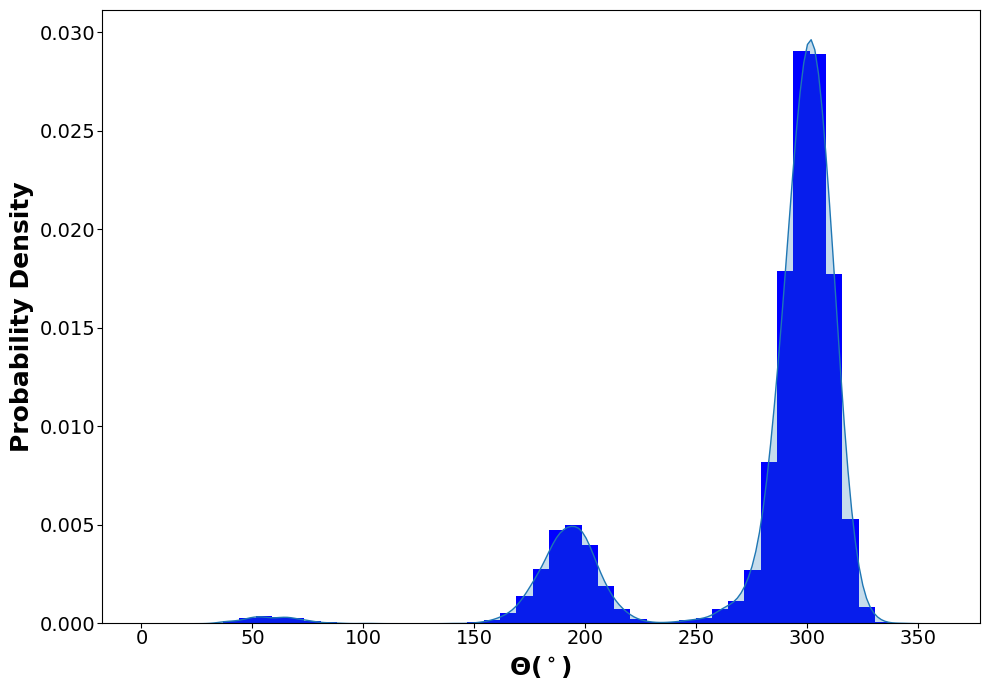

In [5]:
Dihedra_Angles = np.array(Dihedra_Angles)

# Plot the probability density curve
fig, ax = plt.subplots(figsize=(10, 7))
bins=np.linspace(0, 360, num=50)
ax.hist(Dihedra_Angles, bins, density=True, color=['blue'])
sns.kdeplot(Dihedra_Angles, fill=True, bw_adjust=0.5)

plt.xlabel(r'$\bf{\Theta}$($^\circ$)', fontsize = 18.0, fontweight="bold")
plt.ylabel('Probability Density', fontsize = 18.0, fontweight="bold")
plt.tick_params(labelsize=14, pad=1)

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


plt.tight_layout()
plt.show()

##### The above probability density plot shows three peaks for our sample trajecyory. The boundary between peak 1 and 2 is approximate 120¬∞ while the boundary between peak 2 and 3 is approximately 240¬∞. From these data, one can select the parameter below for this conditional activiity analysis:
    * No_of_peaks_protein = 3,
    * peak_boundaries_protein = [120,240],
    * states_protein = "XYZ",
The three peaks were designated X, Y and Z.

Do same for nucelic acid residue to get the dihedral angle distributions of the residue of interest. Extract the number of peaks and boundary between peaks

In [6]:
# Initialize the CONDACT analysis
# Select arguments or parameters based on the content of your system i.e protein or nucleic acids

Study = CONDACT(universe=universe,
                selected_resid='1-3',               # Select the residues of interest eg. here 1 to 3
                No_of_peaks_protein=3,              # The number of peaks for protein is 3 
                peak_boundaries_protein=[120, 240], # Selected 120¬∞ and 240¬∞ from our probability density plot default [120,240]
                states_protein="XYZ",               # Select any letter to designate state
                No_of_peaks_nucleic=3,              # The number of peaks for nucleic. Rememeber to find number of peaks for nucleic. 
                peak_boundaries_nucleic=[140, 330], # Select the boundary between peaks for nucleic eg. default is 140¬∞ and 330¬∞. Remember to determine peaks.
                states_nucleic="SAS",               # Select any letter to designate state
                saving_frequency=10,                # Saving frequency of trajectory in picoseconds
                keep_negative=False                 # All negative dihedral will be converted to secondary angles
            )

In [7]:
# Calculate the conditional activity, persistence time and exchange for the residue(s) of interest
conditional_activity, persistence_times, exchange_times = Study.mean_conditional_activity()

GLN 1 or ASN 2 had statistically fewer transitions hence Conditional Activity A[GLN 1][ASN 2] could not be determine.
ASN 2 or GLN 1 had statistically fewer transitions hence Conditional Activity A[ASN 2][GLN 1] could not be determine.
ASN 2 or ASN 2 had statistically fewer transitions hence Conditional Activity A[ASN 2][ASN 2] could not be determine.
ASN 2 or ASP 3 had statistically fewer transitions hence Conditional Activity A[ASN 2][ASP 3] could not be determine.
ASP 3 or ASN 2 had statistically fewer transitions hence Conditional Activity A[ASP 3][ASN 2] could not be determine.


##### The conditional activity analysis above returns the following output files
* Dihedral_Angle.csv - contains the dihedral angle of each residue for each frame and time in picoseconds
* transition_times.pkl - contains the transition times for each residue of interest during the simulation
* wait_times.pkl - contains the wait times for each residue of interest during the simulation
* Conditional_Activity_list.npy - contains conditional activity in a list of lists format
* Conditional_Activity_matrix.npy - contains square nxn conditional activity matrix. Can be reloaded with numpy for downstream analysis
* Dynamic_Memory.npy - contains the dynamical memory i.e self conditional activity and it the diagonal of the conditional activity matrix. Shows residues whose dynamics are not random. 

Note:
1. The off diagonal entries shows inter-residue conditional activity and the route of information transmission. 
2. If conditional activity A[X][Y] = nan, it means the conformational states or either X, Y or both did not undergo many trasnsitions and many conformational states was not sampled. Our code works for very long trajectory capturing many transitions.


In [8]:
# ‚è±Ô∏è Display Persistence Times of residues
for k, v in persistence_times.items():
    print(f"{k}: {v:.4f}")

GLN 1: 947.1317
ASN 2: 0.0000
ASP 3: 3805.0617


In [9]:
# ‚è±Ô∏è Display Exchange Times of between residues in an N X N matrix

interested, residue_names, residue_type = Study.residues()
labels = [f"{residue_names[i]} {residue_type[i].resid}" for i in range(len(residue_type))]

df_exchange = pd.DataFrame(exchange_times, index=labels, columns=labels)
df_exchange.style.format("{:.4f}").background_gradient(cmap='viridis')

In [68]:
# Load the conditional activity matrix

CA_matrix = np.load("Conditional_Activity_list.npy")
CA_matrix

array([[ 1.08537757,         nan, -1.17143167],
       [        nan,         nan,         nan],
       [ 3.60661146,         nan,  1.58959137]])

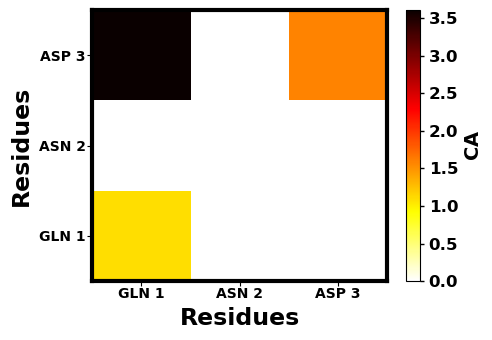

In [65]:
# Conditional_activity is a 2D square matrix
# And residue_names, residue_type have already been extracted:
# interested, residue_names, residue_type = Study.residues()

labels = [f"{residue_names[i]} {residue_type[i].resid}" for i in range(len(residue_type))]

fig, ax = plt.subplots(figsize=(5, 3.5))
orig_map = plt.get_cmap('hot')
reversed_map = orig_map.reversed()

im = ax.imshow(conditional_activity, interpolation='nearest', origin='lower',
               cmap=reversed_map, aspect='auto', vmin=0)

# Colorbar setup
cbar2 = fig.colorbar(im)
cbar2.ax.set_ylabel(r'$\it\bf CA$', fontsize=14.0, fontweight="bold")
cbar2.ax.tick_params(axis='y', labelsize=12, length=3, width=1)

# Axis labels
plt.xlabel("Residues", fontsize=17.0, fontweight="bold")
plt.ylabel("Residues", fontsize=17.0, fontweight="bold")
plt.tick_params(labelsize=16, pad=1)

# Tick labels for residues
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=0, fontsize=10)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels, fontsize=10)

# Spine styling
ax.spines["top"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.spines["right"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)

# Save or show
plt.tight_layout()
plt.show()


##### Dynamical memory reveals residues whose dynamics are statistcially significant i.e not random. The more positive the dynamical memory, the higher the probability the dynamics of that residue is not due to chance.

In [70]:
# Extract and display the dynamical memory of each residue from the conditional activity matrix

dynamical_memory = np.diag(np.array(conditional_activity))

# Create dictionary of residue ‚Üí dynamic memory
residue_dynamic_memory = dict(zip(labels, dynamical_memory))

# Print nicely
print("Residue\t\tDynamic Memory")
for res, val in residue_dynamic_memory.items():
    print(f"{res:<10}\t{val:.4f}")


Residue		Dynamic Memory
GLN 1     	1.0854
ASN 2     	nan
ASP 3     	1.5896


##### The principal eigenvector of the conditional activity matrix reveals dynamically connected domains. The residues contributing to the principal eigenvector of that domain can be identified. Before computing principal eigenvector, we replace NaN with 0.0

In [78]:
# Replace NaN values with 0 using boolean indexing
CA_matrix[np.isnan(CA_matrix)] = 0

CA_matrix


array([[ 1.08537757,  0.        , -1.17143167],
       [ 0.        ,  0.        ,  0.        ],
       [ 3.60661146,  0.        ,  1.58959137]])

In [72]:
# Symmetrize the conditional Activity matrix (mean with its transpose)
CA_sym = 0.5 * (CA_matrix + CA_matrix.T)

CA_sym

array([[1.08537757, 0.        , 1.21758989],
       [0.        , 0.        , 0.        ],
       [1.21758989, 0.        , 1.58959137]])

In [73]:
# Diagonalize symmetric matrix
# Returns eigenvalues in ascending order and orthonormal eigenvectors
vals, vecs = np.linalg.eigh(CA_sym)
vals

array([0.        , 0.0940686 , 2.58090035])

##### 'vals' is a 1D array of eigenvalues sorted ascending. 'vecs' is a matrix whose columns are the corresponding orthonormal eigenvectors.

In [74]:
# Select largest eigenvalue/eigenvector
# Find the index (idx) of the largest eigenvalue (by value, not magnitude).
# Grab that eigenvalue (lam_max) and its eigenvector (v_max = corresponding column of vecs).

idx = np.argmax(vals)
lam_max = vals[idx]
v_max = vecs[:, idx]

# Normalize (just in case)
v_max = v_max / np.linalg.norm(v_max)

In [82]:
# Create dictionary of residue ‚Üí Principal Eigenvector
prin_eigen = dict(zip(labels, v_max))

print(f"Maximum eigenvalue: {lam_max} \n")

# Print nicely
print("Residue\t\tPrincipal Eigenvector")
for res, val in prin_eigen.items():
    print(f"{res:<10}\t{val:.4f}")

Maximum eigenvalue: 2.580900349599186 

Residue		Principal Eigenvector
GLN 1     	-0.6314
ASN 2     	0.0000
ASP 3     	-0.7755
